# Without Filter

In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
    
import matplotlib.pyplot as plt
import numpy as np

In [2]:

# -------------------------
# Hyperparameters
# -------------------------
GAMMA = 0.99
LR = 1e-4
BATCH_SIZE = 64

device = torch.device("mps")
print(f"Using device: {device}")

Using device: mps


In [3]:
class ReplayBuffer:
    def __init__(self, capacity=1_000_000):
        self.buffer = deque(maxlen=capacity)

    def push(self, s, a, r, s2, d):
        self.buffer.append((s, a, r, s2, d))

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        s, a, r, s2, d = map(np.array, zip(*batch))
        return (
            torch.FloatTensor(s).to(device),
            torch.FloatTensor(a).to(device),
            torch.FloatTensor(r).unsqueeze(1).to(device),
            torch.FloatTensor(s2).to(device),
            torch.FloatTensor(d).unsqueeze(1).to(device),
        )

    def __len__(self):
        return len(self.buffer)


In [4]:
LOG_STD_MIN = -20
LOG_STD_MAX = 2

class Actor(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
        )
        self.mu = nn.Linear(256, act_dim)
        self.log_std = nn.Linear(256, act_dim)

    def forward(self, state):
        x = self.net(state)
        mu = self.mu(x)
        log_std = torch.clamp(self.log_std(x), LOG_STD_MIN, LOG_STD_MAX)
        std = torch.exp(log_std)
        return mu, std

    def sample(self, state):
        mu, std = self(state)
        dist = torch.distributions.Normal(mu, std)
        z = dist.rsample()
        action = torch.tanh(z)

        log_prob = dist.log_prob(z) - torch.log(1 - action.pow(2) + 1e-6)
        log_prob = log_prob.sum(dim=1, keepdim=True)

        return action, log_prob


In [5]:
class Critic(nn.Module):
    def __init__(self, obs_dim, act_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim + act_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
        )

    def forward(self, state, action):
        return self.net(torch.cat([state, action], dim=1))


In [6]:
env = gym.make("Pendulum-v1")
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.shape[0]
act_limit = env.action_space.high[0]

actor = Actor(obs_dim, act_dim).to(device)
critic1 = Critic(obs_dim, act_dim).to(device)
critic2 = Critic(obs_dim, act_dim).to(device)
target1 = Critic(obs_dim, act_dim).to(device)
target2 = Critic(obs_dim, act_dim).to(device)

target1.load_state_dict(critic1.state_dict())
target2.load_state_dict(critic2.state_dict())

actor_optim = optim.Adam(actor.parameters(), lr=3e-4)
critic_optim = optim.Adam(
    list(critic1.parameters()) + list(critic2.parameters()), lr=3e-4
)

alpha = 0.2
gamma = 0.99
tau = 0.005

buffer = ReplayBuffer()

In [7]:
print(env.unwrapped.__doc__)



    ## Description

    The inverted pendulum swingup problem is based on the classic problem in control theory.
    The system consists of a pendulum attached at one end to a fixed point, and the other end being free.
    The pendulum starts in a random position and the goal is to apply torque on the free end to swing it
    into an upright position, with its center of gravity right above the fixed point.

    The diagram below specifies the coordinate system used for the implementation of the pendulum's
    dynamic equations.

    ![Pendulum Coordinate System](/_static/diagrams/pendulum.png)

    - `x-y`: cartesian coordinates of the pendulum's end in meters.
    - `theta` : angle in radians.
    - `tau`: torque in `N m`. Defined as positive _counter-clockwise_.

    ## Action Space

    The action is a `ndarray` with shape `(1,)` representing the torque applied to free end of the pendulum.

    | Num | Action | Min  | Max |
    |-----|--------|------|-----|
    | 0   | Torque | -2.

In [8]:
state, _ = env.reset()
episode_rewards_no_hpf = []
current_episode_reward = 0

for step in range(30_000):

    with torch.no_grad():
        s = torch.FloatTensor(state).unsqueeze(0).to(device)
        a, _ = actor.sample(s)
        action = (a * act_limit).cpu().numpy()[0]

    next_state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    current_episode_reward += reward
    
    buffer.push(state, action, reward, next_state, done)
    state = next_state
    
    if done:
        episode_rewards_no_hpf.append(current_episode_reward)
        current_episode_reward = 0
        state, _ = env.reset()

    if len(buffer) < 256:
        continue

    states, actions, rewards, next_states, dones = buffer.sample(256)

    # ----- Critic update -----
    with torch.no_grad():
        next_actions, logp = actor.sample(next_states)
        next_actions = next_actions * act_limit
        q1_t = target1(next_states, next_actions)
        q2_t = target2(next_states, next_actions)
        q_target = rewards + gamma * (1 - dones) * (torch.min(q1_t, q2_t) - alpha * logp)

    q1 = critic1(states, actions)
    q2 = critic2(states, actions)
    critic_loss = ((q1 - q_target)**2 + (q2 - q_target)**2).mean()

    critic_optim.zero_grad()
    critic_loss.backward()
    critic_optim.step()

    # ----- Actor update -----
    actions_new, logp = actor.sample(states)
    actions_new = actions_new * act_limit
    q1_new = critic1(states, actions_new)
    q2_new = critic2(states, actions_new)
    actor_loss = (alpha * logp - torch.min(q1_new, q2_new)).mean()

    actor_optim.zero_grad()
    actor_loss.backward()
    actor_optim.step()

    # ----- Target update -----
    for t, s in zip(target1.parameters(), critic1.parameters()):
        t.data.copy_(tau * s.data + (1 - tau) * t.data)

    for t, s in zip(target2.parameters(), critic2.parameters()):
        t.data.copy_(tau * s.data + (1 - tau) * t.data)

    if step % 5000 == 0:
        print(f"Step {step}")

Step 5000
Step 10000
Step 15000
Step 20000
Step 25000


In [9]:
# env = gym.make("Pendulum-v1", render_mode="human")
# state, _ = env.reset(seed=42)
# done = False
# state_vars = []

# while not done:
#     with torch.no_grad():
#         s = torch.FloatTensor(state).unsqueeze(0).to(device)
#         action, _ = actor.sample(s)
#         action = (action * act_limit).cpu().numpy()[0]

#     state, _, terminated, truncated, _ = env.step(action)
#     state_vars.append(state)
#     done = terminated or truncated

# env.close()


In [10]:
def rollout_actions(env, actor, act_limit, device, seed=42):
    state, _ = env.reset(seed=seed)
    done = False

    actions = []
    states = []

    while not done:
        with torch.no_grad():
            s = torch.FloatTensor(state).unsqueeze(0).to(device)
            a, _ = actor.sample(s)
            action = (a * act_limit).cpu().numpy()[0]  # shape (1,)

        state, _, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        actions.append(action[0])  # store scalar torque
        states.append(state)

    return np.array(actions), np.array(states)


In [27]:
# Environment for evaluation (NO wrappers)
env_eval = gym.make("Pendulum-v1")

# Rollout baseline agent
actions_before, states_before = rollout_actions(
    env_eval, actor, act_limit, device, seed=42
)

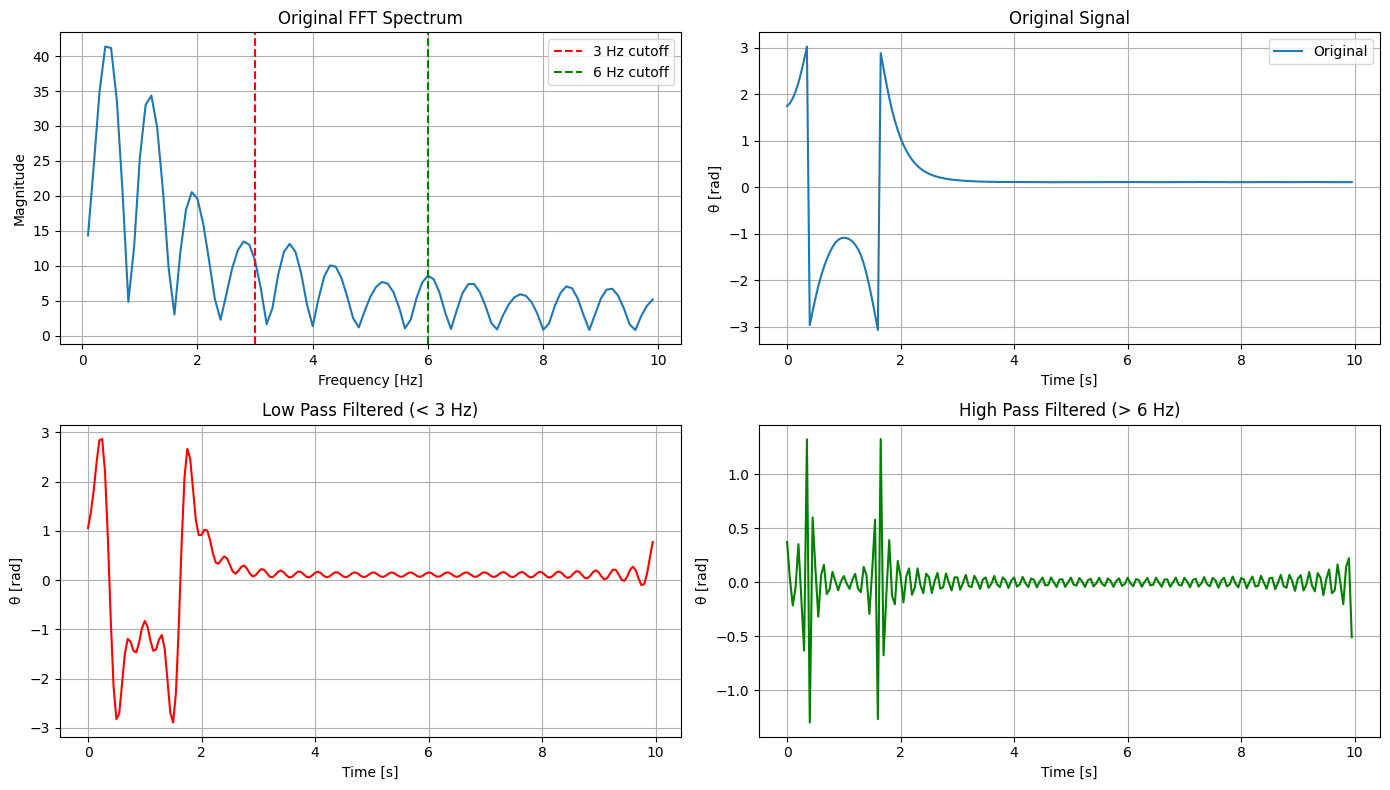

In [28]:
# Extract theta from states_before and compute FFT
states_before_array = np.array(states_before)
theta = np.arctan2(states_before_array[:,1], states_before_array[:,0])

# FFT parameters
dt = env.unwrapped.dt  # Pendulum timestep
N = len(theta)
theta_fft = np.fft.fft(theta)
freqs = np.fft.fftfreq(N, d=dt)

lpf = 3
hpf = 6

# Apply low pass filter at 3 Hz
theta_fft_lowpass = theta_fft.copy()
theta_fft_lowpass[np.abs(freqs) > lpf] = 0
theta_lowpass = np.fft.ifft(theta_fft_lowpass).real

# Apply high pass filter at 6 Hz
theta_fft_highpass = theta_fft.copy()
theta_fft_highpass[np.abs(freqs) < hpf] = 0
theta_highpass = np.fft.ifft(theta_fft_highpass).real

# Use only positive frequencies for plotting
mask = freqs > 0

# Plot FFT magnitude and filtered signals
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Original FFT
axes[0, 0].plot(freqs[mask], np.abs(theta_fft[mask]))
axes[0, 0].axvline(lpf, color='r', linestyle='--', label=f'{lpf} Hz cutoff')
axes[0, 0].axvline(hpf, color='g', linestyle='--', label=f'{hpf} Hz cutoff')
axes[0, 0].set_xlabel("Frequency [Hz]")
axes[0, 0].set_ylabel("Magnitude")
axes[0, 0].set_title("Original FFT Spectrum")
axes[0, 0].legend()
axes[0, 0].grid(True)

# Original signal
time = np.arange(N) * dt
axes[0, 1].plot(time, theta, label='Original')
axes[0, 1].set_xlabel("Time [s]")
axes[0, 1].set_ylabel("θ [rad]")
axes[0, 1].set_title("Original Signal")
axes[0, 1].legend()
axes[0, 1].grid(True)

# Low pass filtered
axes[1, 0].plot(time, theta_lowpass, color='red')
axes[1, 0].set_xlabel("Time [s]")
axes[1, 0].set_ylabel("θ [rad]")
axes[1, 0].set_title(f"Low Pass Filtered (< {lpf} Hz)")
axes[1, 0].grid(True)

# High pass filtered
axes[1, 1].plot(time, theta_highpass, color='green')
axes[1, 1].set_xlabel("Time [s]")
axes[1, 1].set_ylabel("θ [rad]")
axes[1, 1].set_title(f"High Pass Filtered (> {hpf} Hz)")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

In [14]:
# Energy = sum of squared magnitudes

# Band 1: 0 to  lpf Hz
mask_band1 = np.abs(freqs) <= lpf
energy_band1 = np.sum(np.abs(theta_fft[mask_band1])**2)

# Band 2: lpf to hpf Hz
mask_band2 = (np.abs(freqs) > lpf) & (np.abs(freqs) <= hpf)
energy_band2 = np.sum(np.abs(theta_fft[mask_band2])**2)

# Band 3: hpf Hz and above
mask_band3 = np.abs(freqs) > hpf    
energy_band3 = np.sum(np.abs(theta_fft[mask_band3])**2)

# Total energy
total_energy = energy_band1 + energy_band2 + energy_band3

print(f"Energy Distribution:")
print(f"  Band 1 (0-{lpf} Hz):   {energy_band1:.2f} ({100*energy_band1/total_energy:.1f}%)")
print(f"  Band 2 ({lpf}-{hpf} Hz):   {energy_band2:.2f} ({100*energy_band2/total_energy:.1f}%)")
print(f"  Band 3 (>{hpf} Hz):    {energy_band3:.2f} ({100*energy_band3/total_energy:.1f}%)")
print(f"  Total:             {total_energy:.2f}")



Energy Distribution:
  Band 1 (0-3 Hz):   26981.97 (83.8%)
  Band 2 (3-6 Hz):   3369.20 (10.5%)
  Band 3 (>6 Hz):    1851.32 (5.7%)
  Total:             32202.49


In [15]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

print(sigmoid(energy_band1/total_energy))
print(sigmoid(energy_band2/total_energy))
print(sigmoid(energy_band3/total_energy))

0.6980195
0.5261326
0.5143685


# With Filter

In [16]:
from scipy.signal import butter, lfilter, lfilter_zi
import numpy as np
import gymnasium as gym

class BandLimitedRewardWrapper(gym.Wrapper):
    def __init__(
        self,
        env,
        fs=20.0,
        cutoff_hz=6.0,
        lambda_lpf=0.1,
        lambda_w=0.01
    ):
        super().__init__(env)

        self.lambda_lpf = lambda_lpf
        self.lambda_w = lambda_w

        nyq = 0.5 * fs
        self.b, self.a = butter(2, cutoff_hz / nyq, btype="low")
        self.zi = lfilter_zi(self.b, self.a)

    def reset(self, **kwargs):
        obs, info = self.env.reset(**kwargs)
        self.zi = lfilter_zi(self.b, self.a)
        return obs, info

    def step(self, action):
        # ---- action handling (CRITICAL) ----
        u = float(action)                     # scalar for filtering
        action_env = np.array([u], dtype=np.float32)  # shape (1,) for Pendulum

        obs, reward, terminated, truncated, info = self.env.step(action_env)

        # ---- LPF reference (scalar-safe) ----
        u_lpf, self.zi = lfilter(self.b, self.a, [u], zi=self.zi)
        u_lpf = u_lpf[0]

        # ---- penalties ----
        band_penalty = -self.lambda_lpf * (u - u_lpf)**2

        _, _, theta_dot = obs
        vel_penalty = -self.lambda_w * theta_dot**2

        reward += band_penalty + vel_penalty

        return obs, reward, terminated, truncated, info


In [17]:
env_smooth = BandLimitedRewardWrapper(
    gym.make("Pendulum-v1"),
    cutoff_hz=6.0,
    lambda_lpf=0.1,
    lambda_w=0.01
)


actor_smooth = Actor(obs_dim, act_dim).to(device)
critic1_smooth = Critic(obs_dim, act_dim).to(device)
critic2_smooth = Critic(obs_dim, act_dim).to(device)
target1_smooth = Critic(obs_dim, act_dim).to(device)
target2_smooth = Critic(obs_dim, act_dim).to(device)

target1_smooth.load_state_dict(critic1_smooth.state_dict())
target2_smooth.load_state_dict(critic2_smooth.state_dict())

actor_optim_smooth = optim.Adam(actor_smooth.parameters(), lr=3e-4)
critic_optim_smooth = optim.Adam(
    list(critic1_smooth.parameters()) + list(critic2_smooth.parameters()), lr=3e-4
)

buffer_smooth = ReplayBuffer()


In [18]:
state, _ = env_smooth.reset()

for step in range(30_000):

    with torch.no_grad():
        s = torch.FloatTensor(state).unsqueeze(0).to(device)
        a, _ = actor_smooth.sample(s)
        action = (a * act_limit).cpu().numpy()[0]

    next_state, reward, terminated, truncated, _ = env_smooth.step(action)
    done = terminated or truncated

    buffer_smooth.push(state, action, reward, next_state, done)
    state = next_state

    if done:
        state, _ = env_smooth.reset()

    if len(buffer_smooth) < 256:
        continue

    states, actions, rewards, next_states, dones = buffer_smooth.sample(256)

    with torch.no_grad():
        next_actions, logp = actor_smooth.sample(next_states)
        next_actions = next_actions * act_limit
        q1_t = target1_smooth(next_states, next_actions)
        q2_t = target2_smooth(next_states, next_actions)
        q_target = rewards + gamma * (1 - dones) * (torch.min(q1_t, q2_t) - alpha * logp)

    q1 = critic1_smooth(states, actions)
    q2 = critic2_smooth(states, actions)
    critic_loss = ((q1 - q_target)**2 + (q2 - q_target)**2).mean()

    critic_optim_smooth.zero_grad()
    critic_loss.backward()
    critic_optim_smooth.step()

    actions_new, logp = actor_smooth.sample(states)
    actions_new = actions_new * act_limit
    q1_new = critic1_smooth(states, actions_new)
    q2_new = critic2_smooth(states, actions_new)
    actor_loss = (alpha * logp - torch.min(q1_new, q2_new)).mean()

    actor_optim_smooth.zero_grad()
    actor_loss.backward()
    actor_optim_smooth.step()

    for t, s in zip(target1_smooth.parameters(), critic1_smooth.parameters()):
        t.data.copy_(tau * s.data + (1 - tau) * t.data)

    for t, s in zip(target2_smooth.parameters(), critic2_smooth.parameters()):
        t.data.copy_(tau * s.data + (1 - tau) * t.data)
        
    if step % 5000 == 0:
        print(f"Step {step}")


/var/folders/x9/dh89t46x5_z5tc2g4ynx0kj40000gn/T/ipykernel_14390/1122265786.py:30: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  u = float(action)                     # scalar for filtering


Step 5000
Step 10000
Step 15000
Step 20000
Step 25000


In [19]:
env_eval = gym.make("Pendulum-v1")
state, _ = env_eval.reset(seed=42)
done = False
state_vars_smooth = []

while not done:
    with torch.no_grad():
        s = torch.FloatTensor(state).unsqueeze(0).to(device)
        action, _ = actor_smooth.sample(s)
        action = (action * act_limit).cpu().numpy()[0]

    state, _, terminated, truncated, _ = env_eval.step(action)
    state_vars_smooth.append(state)
    done = terminated or truncated

env_eval.close()


In [20]:
state_vars_smooth = np.array(state_vars_smooth)
theta_smooth = np.arctan2(state_vars_smooth[:,1], state_vars_smooth[:,0])

theta_fft_smooth = np.fft.fft(theta_smooth)
freqs_smooth = np.fft.fftfreq(len(theta_smooth), d=dt)


In [21]:
def band_energy(theta_fft, freqs, lpf, hpf):
    e1 = np.sum(np.abs(theta_fft[np.abs(freqs) <= lpf])**2)
    e2 = np.sum(np.abs(theta_fft[(np.abs(freqs) > lpf) & (np.abs(freqs) <= hpf)])**2)
    e3 = np.sum(np.abs(theta_fft[np.abs(freqs) > hpf])**2)
    tot = e1 + e2 + e3
    return e1/tot, e2/tot, e3/tot


In [22]:
e_no = band_energy(theta_fft, freqs, lpf, hpf)
e_sm = band_energy(theta_fft_smooth, freqs_smooth, lpf, hpf)

print("=== Energy Fraction Comparison ===")
print(f"Before  >{hpf} Hz: {100*e_no[2]:.2f}%")
print(f"After   >{hpf} Hz: {100*e_sm[2]:.2f}%")


=== Energy Fraction Comparison ===
Before  >6 Hz: 5.75%
After   >6 Hz: 5.87%


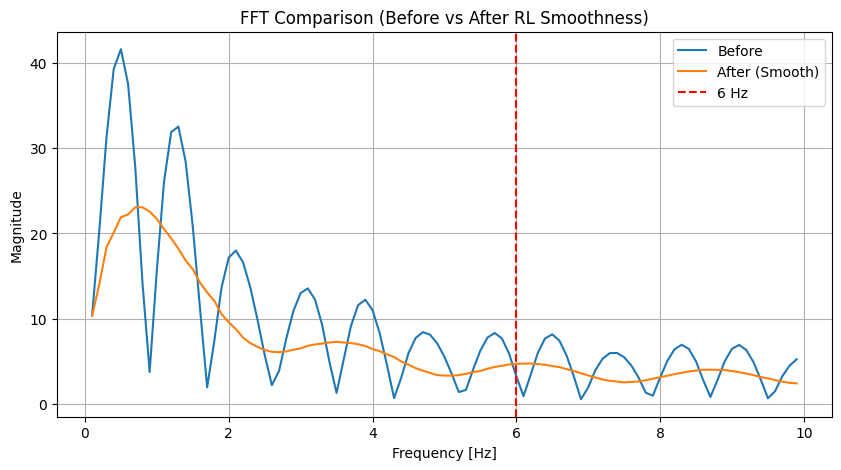

In [23]:
mask = freqs > 0

plt.figure(figsize=(10,5))
plt.plot(freqs[mask], np.abs(theta_fft[mask]), label="Before")
plt.plot(freqs_smooth[mask], np.abs(theta_fft_smooth[mask]), label="After (Smooth)")
plt.axvline(hpf, color="r", linestyle="--", label="6 Hz")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.title("FFT Comparison (Before vs After RL Smoothness)")
plt.legend()
plt.grid(True)
plt.show()


In [24]:


# Rollout smooth / band-limited agent
actions_after, states_after = rollout_actions(
    env_eval, actor_smooth, act_limit, device, seed=42
)

env_eval.close()


In [25]:
dt = env_eval.unwrapped.dt  # Pendulum timestep
N_before = len(actions_before)
N_after = len(actions_after)

fft_before = np.fft.fft(actions_before)
fft_after = np.fft.fft(actions_after)

freqs_before = np.fft.fftfreq(N_before, d=dt)
freqs_after = np.fft.fftfreq(N_after, d=dt)


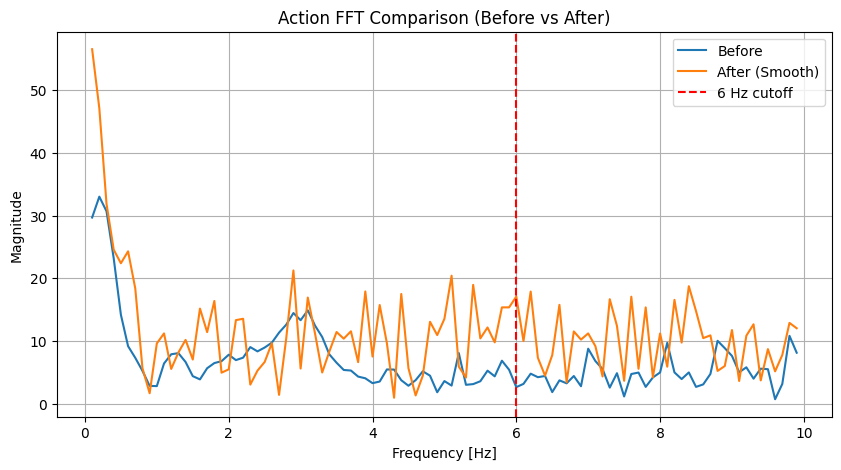

In [26]:
mask_b = freqs_before > 0
mask_a = freqs_after > 0

plt.figure(figsize=(10, 5))
plt.plot(freqs_before[mask_b], np.abs(fft_before[mask_b]), label="Before")
plt.plot(freqs_after[mask_a], np.abs(fft_after[mask_a]), label="After (Smooth)")
plt.axvline(6.0, color="r", linestyle="--", label="6 Hz cutoff")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.title("Action FFT Comparison (Before vs After)")
plt.legend()
plt.grid(True)
plt.show()
